# Retrain RF on new data

In [7]:
# install.packages("stringdist")

In [1]:
library(dplyr)
library(data.table)
library(partykit)
library(tictoc)
library(caret)
library(e1071)
library(randomForest)
library(ranger)

#for 3d plotting
library(akima)
library(plotly)

# for prep data
library(rPython)
library(stringr)
library(pbapply)
library(stringdist)
library(data.table)

getwd()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: lattice

Loading required package: ggplot2

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘ranger’


The following object is masked from ‘package:randomForest’:

    importance



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:sta

[1] "/home/jupyter/local/Domains_202003/scripts/phaseII_gcloudaccess"

In [2]:

source('../orig/functions.R')

source('../orig/functions_models.R')

source('functions_eval.R')


# Load data

In [3]:
system("gsutil cp gs://data_outputt/output/expiry_train_prepped_2 /home/jupyter/local/Domains_202003/data/expiry_train_prepped_2")
expiry_train_prepped_2 <- readRDS("/home/jupyter/local/Domains_202003/data/expiry_train_prepped_2")

system("gsutil cp gs://data_outputt/output/expiry_test_prepped_2 /home/jupyter/local/Domains_202003/data/expiry_test_prepped_2")
expiry_test_prepped_2 <- readRDS("/home/jupyter/local/Domains_202003/data/expiry_test_prepped_2")


expiry_train_df <- rbindlist(expiry_train_prepped_2, fill=TRUE)
expiry_test_df <- rbindlist(expiry_test_prepped_2, fill=TRUE)

In [5]:
dim(expiry_train_df)
dim(expiry_test_df)

[1] 1394366      39

[1] 348591     39

# Retrain Ranger_03

## per the same definitions as in dtree_xl.ipynb, but added reg_arpt as a predictor

In [11]:
names(expiry_train_df)

[1] "renewal_type"         "renewed_count"        "expiry_date"         
 [4] "domain_id"            "domain"               "creation_date"       
 [7] "status"               "tld"                  "registrar"           
[10] "reseller"             "reseller_country"     "region"              
[13] "reg_period"           "registrant_country"   "renewal_status"      
[16] "renew_mbg"            "renew_type"           "autorenew_type"      
[19] "renew_date"           "renew_registrar"      "renew_reseller"      
[22] "reg_revenue"          "reg_arpt"             "renew_period"        
[25] "renew_domain_revenue" "renew_arpt"           "reg_arpt_org"        
[28] "tld_registrar_index"  "sld"                  "sld_type"            
[31] "sld_length"           "sld_type2"            "day_domains"         
[34] "log_reg_arpt"         "gibb_score"           "cluster"             
[37] "pattern"              "pattern_score"        "pattern_domain_count"

In [14]:
na_df <- expiry_train_df %>%
  summarise_all(funs(sum(is.na(.))))
t(na_df)

renewal_type,0
renewed_count,0
expiry_date,0
domain_id,0
domain,0
creation_date,0
status,0
tld,0
registrar,0
reseller,0
reseller_country,0


In [19]:
expiry_train_df_sub <- subset(expiry_train_df, 
       select = c(renewal_status, tld, registrar, reseller, reseller_country, region, reg_period, 
                  sld_type, sld_length, day_domains, gibb_score, pattern_domain_count,reg_arpt) )
head(expiry_train_df_sub)

renewal_status,tld,registrar,reseller,reseller_country,region,reg_period,sld_type,sld_length,day_domains,gibb_score,pattern_domain_count,reg_arpt
<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<int>,<fct>,<int>,<int>,<dbl>,<int>,<dbl>
Renewed,fun,1&1 internet,1&1 internet,Germany,Non China,1,ln,8,51,5.95,1,15
Renewed,fun,1&1 internet,1&1 internet,Germany,Non China,1,l,3,51,0.57,1,15
Not Renewd,fun,1&1 internet,1&1 internet,Germany,Non China,1,hyphen-l,10,51,5.09,4,15
Renewed,fun,1&1 internet,1&1 internet,Germany,Non China,1,ln,3,51,5.63,1,15
Renewed,fun,1&1 internet,1&1 internet,Germany,Non China,1,ln,3,51,5.89,1,15
Renewed,fun,1&1 internet,1&1 internet,Germany,Non China,1,l,11,51,8.40,1,15


In [20]:
# # model fitting: 952.151 sec elapsed
# # model saving: 163.762 sec elapsed


# tic("model fitting")

# ranger_03_expiry <- ranger(
#     formula         = renewal_status ~ ., 
#     data            = expiry_train_df_sub, 
#     importance = 'impurity', 
#     num.trees       = 500,
#     class.weights = c(3,4),
#     probability = TRUE,
#     mtry            = 5,
#     min.node.size   = 10,
#     replace = FALSE,
#     sample.fraction = .725,
#     seed            = 123
# )

# toc()

# tic("model saving")
# save(ranger_03_expiry, file="../../data/output/ranger_03_expiry")
# toc()

Growing trees.. Progress: 4%. Estimated remaining time: 13 minutes, 4 seconds.
Growing trees.. Progress: 8%. Estimated remaining time: 12 minutes, 4 seconds.
Growing trees.. Progress: 12%. Estimated remaining time: 11 minutes, 23 seconds.
Growing trees.. Progress: 16%. Estimated remaining time: 11 minutes, 2 seconds.
Growing trees.. Progress: 20%. Estimated remaining time: 10 minutes, 32 seconds.
Growing trees.. Progress: 25%. Estimated remaining time: 9 minutes, 51 seconds.
Growing trees.. Progress: 29%. Estimated remaining time: 9 minutes, 13 seconds.
Growing trees.. Progress: 33%. Estimated remaining time: 8 minutes, 44 seconds.
Growing trees.. Progress: 37%. Estimated remaining time: 8 minutes, 8 seconds.
Growing trees.. Progress: 41%. Estimated remaining time: 7 minutes, 35 seconds.
Growing trees.. Progress: 45%. Estimated remaining time: 7 minutes, 7 seconds.
Growing trees.. Progress: 49%. Estimated remaining time: 6 minutes, 30 seconds.
Growing trees.. Progress: 53%. Estimated r

## test ranger_03 on expiry_test

In [21]:

# # model predict: 65.851 sec elapsed
# # eval saving: 0.132 sec elapsed

# tic("model predict")
# ranger_predict_03_expiry <- predict(ranger_03_expiry, 
#                           data = expiry_test_df,
#                           type="response")$predictions
# toc()

# tic("eval saving")

# ranger_predict_03_expiry <- as.data.frame(ranger_predict_03_expiry)$Renewed

# save(ranger_predict_03_expiry, 
#      file="../../data/output/ranger_predict_03_expiry")
# toc()


model predict: 65.851 sec elapsed
eval saving: 0.132 sec elapsed


In [22]:
# load("../../data/output/ranger_predict_03_exptest")

In [24]:
# head(ranger_predict_03_exptest)

[1] 0.29780992 0.18199561 0.22687120 0.02133564 0.19347952 0.43249667

In [25]:
length(ranger_predict_03_exptest)

[1] 348591

In [28]:
dim(expiry_test_df)

[1] 348591     39

In [30]:
head((expiry_test_df)$renewal_status)

[1] Renewed    Not Renewd Renewed    Not Renewd Not Renewd Renewed   
Levels: Not Renewd Renewed

In [23]:
# ranger_03_pred_df_expiry = data.frame("actual" = expiry_test_df$renewal_status,
#           "predicted" = ranger_predict_03_expiry)

# # lift df: 23.675 sec elapsed
# # gains plot: 0.046 sec elapsed
# # auc: 0.007 sec elapsed
# tic("lift df")
# lift_df_ranger_03_expiry <- chart_lift(pred_df = ranger_03_pred_df_expiry,
#                         dep_var = "actual",
#                         pred_var = "predicted")

# toc()
# tic("gains plot")
# gains_plot_ranger_03_expiry <- plot_gains (lift_df_ranger_03_expiry) 

# toc()
# tic("auc")
# auc_ranger_03_expiry <- calc_auc(lift_df_ranger_03_expiry)
# toc()


# saveRDS(lift_df_ranger_03_expiry, file.path('../../data/output/',"lift_df_ranger_03_expiry"))


lift df: 1.419 sec elapsed
gains plot: 0.093 sec elapsed
auc: 0.036 sec elapsed


In [11]:
file_list <- c("lift_df_segglm",
                    "lift_df_bendtr",
                    "lift_df_ranger3",
                    "lift_df_ranger_03",
               "lift_df_ranger_03_expiry"
              )
assign(file_list[1], readRDS(sprintf("../../data/%s", file_list[1])))
assign(file_list[2], readRDS(sprintf("../../data/%s", file_list[2])))
assign(file_list[3], readRDS(sprintf("../../data/%s", file_list[3])))
assign(file_list[4], readRDS(sprintf("../../data/%s", file_list[4])))
assign(file_list[5], readRDS(sprintf("../../data/%s", file_list[5])))
     

In [12]:
auc_list= list(
        seg_glm = calc_auc(lift_df_segglm), 
        ben_dtr= calc_auc(lift_df_bendtr), 
        rf_500tr= calc_auc(lift_df_ranger3), 
        rf_newd = calc_auc(lift_df_ranger_03),
        rf_newd_ex= calc_auc(lift_df_ranger_03_expiry))

In [13]:
auc_list

$seg_glm
[1] 0.7343129

$ben_dtr
[1] 0.7031848

$rf_500tr
[1] 0.9045892

$rf_newd
[1] 0.616926

$rf_newd_ex
[1] 0.806467

In [14]:
plot_multigains_03_summ3 <- plot_multigains(
    lift_df_list=list(
        seg_glm = lift_df_segglm, 
        ben_dtr = lift_df_bendtr,
        rf_500tr = lift_df_ranger3,
        rf_newd = lift_df_ranger_03,
        rf_newd_ex = lift_df_ranger_03_expiry),
    auc_list = list(
        seg_glm = calc_auc(lift_df_segglm), 
        ben_dtr= calc_auc(lift_df_bendtr), 
        rf_500tr= calc_auc(lift_df_ranger3), 
        rf_newd = calc_auc(lift_df_ranger_03),
        rf_newd_ex= calc_auc(lift_df_ranger_03_expiry)))
png(file = "../../data/output/plot_multigains_03_newdata_summ3.png",
    width = 500, height = 375)
plot(plot_multigains_03_summ3)
dev.off()

png 
  2

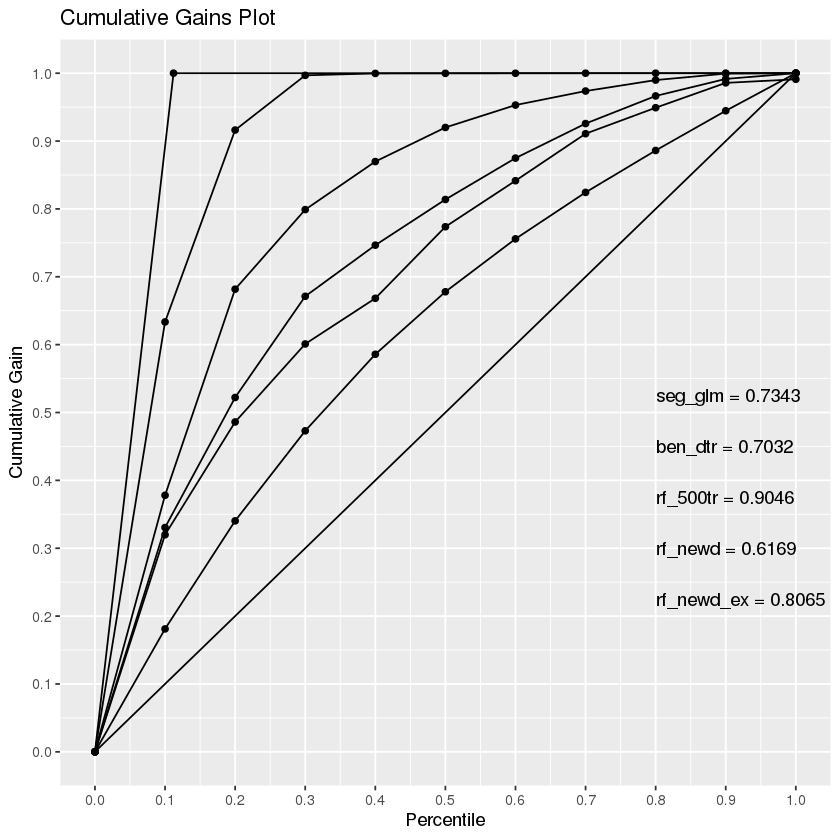

In [15]:
plot_multigains_03_summ3

In [31]:
system("gsutil cp /home/jupyter/local/Domains_202003/data/output/* gs://data_outputt/output/")

In [16]:
lift_df_ranger_03_expiry

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,23076,0.3779976,3.779976
0.2,41620,0.6817586,3.408793
0.3,48777,0.7989942,2.663314
0.4,53100,0.8698074,2.174518
0.5,56166,0.9200301,1.840060
0.6,58182,0.9530533,1.588422
0.7,59443,0.9737092,1.391013
0.8,60430,0.9898768,1.237346
0.9,61014,0.9994431,1.110492


lift_df_ranger3

In [17]:
lift_df_segglm

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,14576,0.3305215,3.305215
0.2,23027,0.5221542,2.610771
0.3,29601,0.6712245,2.237415
0.4,32925,0.7465986,1.866497
0.5,35893,0.8139002,1.627800
0.6,38582,0.8748753,1.458125
0.7,40827,0.9257823,1.322546
0.8,42622,0.9664853,1.208107
0.9,43729,0.9915873,1.101764


# how well does seg_glm perf when trained on this data?

## need to retrain model on expiry_train_prepped_2 (list of dfs)


In [19]:
# model fitting: 38.794 sec elapsed
# model saving: 48.062 sec elapsed
# tic("model fitting")
# first_renewal_model_expiry_train<-mass_build_model_first_renewal(expiry_train_prepped_2)
# toc()
# tic("model saving")
# saveRDS(first_renewal_model_expiry_train, "../../data/output/first_renewal_model_expiry_train")
# toc()


In [56]:
# filename='first_renewal_model'
# system(paste(sprintf("gsutil cp gs://data_input/%s /home/jupyter/local/Domains_202003/data/", filename)))
# assign(filename, readRDS(sprintf("../../data/%s", filename)))
# rm(first_renewal_model)

In [36]:
# filename='first_renewal_model_train' # trained in training subset, like ranger_03
# system(paste(sprintf("gsutil cp gs://data_input/%s /home/jupyter/local/Domains_202003/data/", filename)))
# assign(filename, readRDS(sprintf("../../data/%s", filename)))

# need to use predict from original functions

In [21]:
# model predict: 12.668 sec elapsed

# tic("model predict")
# seg_glm_expiry_exptest <- mass_predict_first_renewal(expiry_test_prepped_2, first_renewal_model_expiry_train)
# toc()
# saveRDS(seg_glm_expiry_exptest,"../../data/output/seg_glm_expiry_exptest")


In [ ]:
# seg_glm_exptest <- readRDS("../../data/output/seg_glm_exptest")

In [22]:
# colSums(is.na(["first_renewal_prediction"]))
# seg_glm_exptest[, sum(is.na(.SD)),  .SDcols = 1:39]

seg_glm_expiry_exptest %>% summarise_all(~ sum(is.na(.)))

renewal_type,renewed_count,expiry_date,domain_id,domain,creation_date,status,tld,registrar,reseller,⋯,sld_length,sld_type2,day_domains,log_reg_arpt,gibb_score,cluster,pattern,pattern_score,pattern_domain_count,first_renewal_prediction
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,1178


In [24]:
1178/dim(seg_glm_expiry_exptest)[1]

[1] 0.003379318

In [25]:
seg_glm_expiry_exptest_pred_df = data.frame("actual" = expiry_test_df$renewal_status,
          "predicted" = seg_glm_expiry_exptest$first_renewal_prediction)

In [26]:
# lift df: 1.63 sec elapsed
# gains plot: 0.03 sec elapsed
# auc: 0.005 sec elapsed

tic("lift df")
lift_df_seg_glm_expiry_exptest <- chart_lift(pred_df = seg_glm_expiry_exptest_pred_df,
                        dep_var = "actual",
                        pred_var = "predicted")

toc()
tic("gains plot")
gains_plot_seg_glm_expiry_exptest <- plot_gains (lift_df_seg_glm_expiry_exptest) 

toc()
tic("auc")
auc_seg_glm_expiry_exptest<- calc_auc(lift_df_seg_glm_expiry_exptest)
toc()


saveRDS(lift_df_seg_glm_expiry_exptest, file.path('../../data/',"lift_df_seg_glm_expiry_exptest"))

lift df: 1.63 sec elapsed
gains plot: 0.03 sec elapsed
auc: 0.005 sec elapsed


In [27]:
lift_df_seg_glm_expiry_exptest

P,actu_renwd2,gain,lift
<dbl>,<int>,<dbl>,<dbl>
0.1,24105,0.3948532,3.948532
0.2,42028,0.6884419,3.442209
0.3,50773,0.8316898,2.772299
0.4,55148,0.9033547,2.258387
0.5,57507,0.9419965,1.883993
0.6,58867,0.9642740,1.607123
0.7,59725,0.9783285,1.397612
0.8,60120,0.9847988,1.230999
0.9,60274,0.9873215,1.097024


In [30]:
plot_multigains_03_summ4 <- plot_multigains(
    lift_df_list=list(
        seg_glm = lift_df_segglm, 
        ben_dtr = lift_df_bendtr,
        rf_500tr = lift_df_ranger3,
        rf_newd_ex = lift_df_ranger_03_expiry,
        seg_newd_ex = lift_df_seg_glm_expiry_exptest),
    auc_list = list(
        seg_glm = calc_auc(lift_df_segglm), 
        ben_dtr= calc_auc(lift_df_bendtr), 
        rf_500tr= calc_auc(lift_df_ranger3),
        rf_newd_ex= calc_auc(lift_df_ranger_03_expiry),
        seg_newd_ex= calc_auc(lift_df_seg_glm_expiry_exptest)))
png(file = "../../data/output/plot_multigains_03_summ4.png",
    width = 500, height = 375)
plot(plot_multigains_03_summ4)
dev.off()

png 
  2

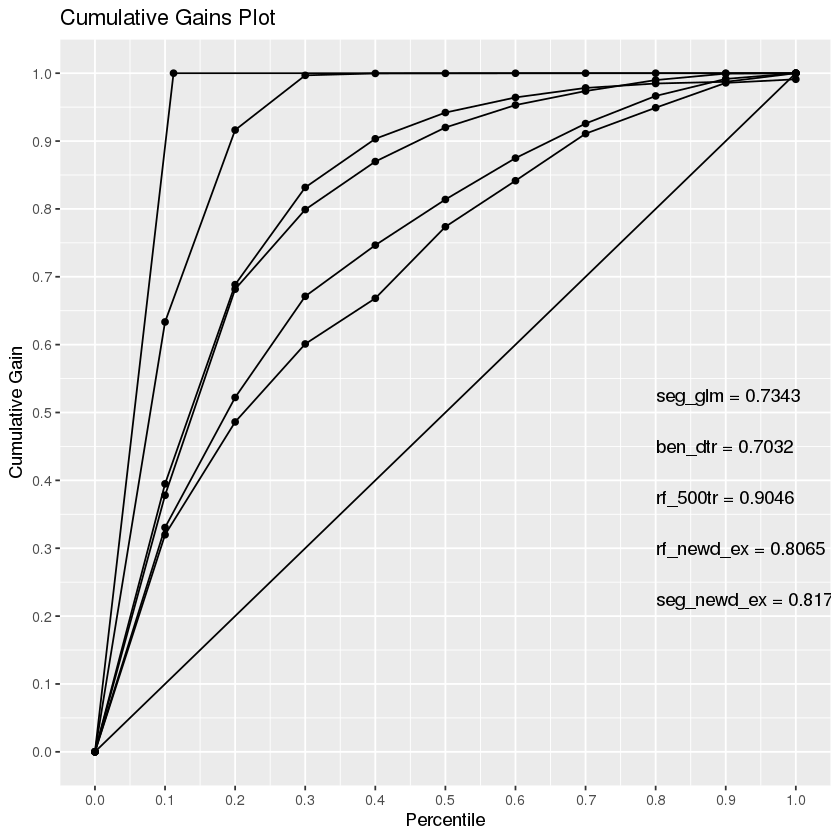

In [31]:
plot_multigains_03_summ4

# but ultimately, client fills NA's with data from "fallback tables", which would improve performance. asked client for script

In [67]:
# from /scripts/nedata_202005/explore

system("gsutil cp gs://data_input/npv_fallback_tables /home/jupyter/local/Domains_202003/data/npv_fallback_tables")

In [68]:
# npv_fallback_tables	
#   fallback tables where we dont have enough training 
#   data for a particular tld-registrar combination

npv_fallback_names <- load("/home/jupyter/local/Domains_202003/data/npv_fallback_tables")
npv_fallback_names

[1] "npv_fallback_first_final"        "npv_fallback_first_geo_arpt"    
 [3] "npv_fallback_first_geo_arpt_tld" "npv_fallback_first_tld_arpt"    
 [5] "npv_fallback_second_final"       "npv_fallback_second_geo"        
 [7] "npv_fallback_second_tld_geo"     "npv_fallback_third_final"       
 [9] "npv_fallback_third_geo"          "npv_fallback_third_tld_geo"

In [64]:
# [1] "npv_fallback_first_final"        "npv_fallback_first_geo_arpt"    
# [3] "npv_fallback_first_geo_arpt_tld" "npv_fallback_first_tld_arpt"    
# [5] "npv_fallback_second_final"       "npv_fallback_second_geo"        
# [7] "npv_fallback_second_tld_geo"     "npv_fallback_third_final"       
# [9] "npv_fallback_third_geo"          "npv_fallback_third_tld_geo" 

In [69]:
head(npv_fallback_first_final)

region,reg_arpt_slab,expiring_domains,renewed_domains,renewal_rate,index
<chr>,<fct>,<int>,<int>,<dbl>,<chr>
China,"(-Inf,0]",35669,2139,0.060,"China(-Inf,0]"
China,"(0,1]",536645,11052,0.021,"China(0,1]"
China,"(1,3]",84869,12063,0.142,"China(1,3]"
China,"(3,5]",1356,340,0.251,"China(3,5]"
China,"(5,10]",177,36,0.203,"China(5,10]"
China,"(10,15]",427,122,0.286,"China(10,15]"


In [64]:
# Questions:
# not enough training means we also don't have "day_domains"?
# npv_fallback_first_final, _geo_arpt? renewal rate by country & buy price
# npv_fallback_first_final$reg_arpt_slab? reg_arpt: the price at which the domain is bought by the reseller 

# Using a decision tree means you don't need to retrain a model but we can do better than simply using a "fall back table" -- can we confirm this with historical data?

Warning message in readChar(con, 5L, useBytes = TRUE):
“cannot open compressed file '/home/jupyter/local/Domains_202003/data/npv_fallback_tables', probable reason 'No such file or directory'”


ERROR: Error in readChar(con, 5L, useBytes = TRUE): cannot open the connection


# Variable importance

In [38]:
# load("../../data/output/ranger_03_expiry") # new expiry data
load("../../data/ranger_03") # original data

In [47]:
as.data.frame(round(sort(ranger_03_expiry$variable.importance, decreasing=TRUE),0))

,"round(sort(ranger_03_expiry$variable.importance, decreasing = TRUE), 0)"
,<dbl>
reg_arpt,265675
day_domains,120616
gibb_score,99629
sld_length,43497
reseller,26344
registrar,21450
pattern_domain_count,19572
tld,17826
reseller_country,15428


In [46]:
as.data.frame(round(sort(ranger_03$variable.importance, decreasing=TRUE),0))

,"round(sort(ranger_03$variable.importance, decreasing = TRUE), 0)"
,<dbl>
day_domains,92600
gibb_score,86059
sld_length,28108
tld,25682
pattern_domain_count,15233
sld_type,12202
reg_period,10154
registrar,8546
reseller,8537
